In [10]:
!python3 -m venv venv
!venv/bin/python -m pip install ipykernel
!venv/bin/python -m ipykernel install --user --name=myenv --display-name "Python (myenv)"
%pip install datasets wandb transformers matplotlib torch-tb-profiler pandas

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Installed kernelspec myenv in /root/.local/share/jupyter/kernels/myenv


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.optim as optim
import numpy as np
import wandb
from tqdm import tqdm
from torch.optim import AdamW
import pandas as pd
torch.cuda.manual_seed_all(423)

/venv/main/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/venv/main/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
project_name = "hpml-hw2-llm3"

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imdb")
print(dataset)

In [ ]:
from transformers import DistilBertForSequenceClassification
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch
from transformers import AutoTokenizer, DataCollatorWithPadding
import time
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

tokenized = dataset.map(tokenize_fn, batched=True)
tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## C1

In [5]:
import wandb

wandb.init(project=project_name, name=f"bs32_lr1e-4", group = "Warm Up Experiment")

wandb.config.update({
    "model_name": "distilbert-base-uncased",
    "max_len": 256,
    "batch_size": 32,
    "lr": 1e-4,
    "optimizer": "AdamW",
    "num_workers": 2,
    "epochs": 5,
    "compile_mode": False
})

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ykmao1515 (kaimao-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:


config = wandb.config

model_name = "distilbert-base-uncased"
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=config.lr)

train_loader = DataLoader(tokenized["train"], batch_size=config.batch_size, shuffle=True, collate_fn=data_collator, num_workers=config.num_workers)
test_loader = DataLoader(tokenized["test"], batch_size=config.batch_size, collate_fn=data_collator, num_workers=config.num_workers)

train_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(config.epochs):
  model.train()
  total_loss = 0
  total_correct = 0
  total_samples = 0
  for batch in tqdm(train_loader):
      optimizer.zero_grad()

      inputs = {
          "input_ids": batch["input_ids"].to(device),
          "attention_mask": batch["attention_mask"].to(device),
          "labels": batch["labels"].to(device),
      }

      outputs = model(**inputs)
      loss = outputs.loss
      loss.backward()
      optimizer.step()

      logits = outputs.logits
      preds = torch.argmax(logits, dim = 1)
      labels = batch["labels"].to(device)
      correct = (preds == labels).sum().item()
      total_correct += correct
      total_samples += len(labels)
      total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  avg_accuracy = total_correct / total_samples
  train_loss.append(avg_loss)
  train_accuracy.append(avg_accuracy)

  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
      for batch in test_loader:
          inputs = {
              "input_ids": batch["input_ids"].to(device),
              "attention_mask": batch["attention_mask"].to(device),
          }
          labels = batch["labels"].to(device)

          logits = model(**inputs).logits
          preds = torch.argmax(logits, dim=1)

          correct += (preds == labels).sum().item()
          total += labels.size(0)

  accuracy = correct / total
  test_accuracy.append(accuracy)

  wandb.log({"train/loss": train_loss,
           "train/acc": avg_accuracy,
           "test/acc": accuracy})
  print(f"Epoch {epoch+1}/{config.epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/782 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variabl

Epoch 1/5, Loss: 0.3088, Train Accuracy: 0.8696, Test Accuracy: 0.8678


  0%|          | 0/782 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 782/782 [00:43<00:00, 17.84it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set th

Epoch 2/5, Loss: 0.1716, Train Accuracy: 0.9369, Test Accuracy: 0.8880


  0%|          | 0/782 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 782/782 [00:44<00:00, 17.50it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set th

Epoch 3/5, Loss: 0.0863, Train Accuracy: 0.9706, Test Accuracy: 0.8694


  0%|          | 0/782 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 782/782 [00:43<00:00, 17.80it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set th

Epoch 4/5, Loss: 0.0522, Train Accuracy: 0.9814, Test Accuracy: 0.8735


  0%|          | 0/782 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 782/782 [00:44<00:00, 17.72it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set th

Epoch 5/5, Loss: 0.0415, Train Accuracy: 0.9856, Test Accuracy: 0.8624


In [7]:
wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


test/acc,▂█▃▄▁
train/acc,▁▅▇██
test/acc,0.86236
train/acc,0.98564


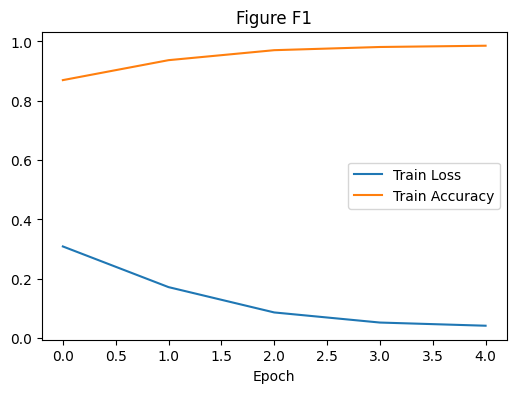

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(train_accuracy, label='Train Accuracy')
plt.xlabel('Epoch')
# plt.ylabel('Value')
plt.title('Figure F1')
plt.legend()
plt.show()

In [9]:
print(train_loss, train_accuracy, test_accuracy)

[0.30880285602282076, 0.1716375277470559, 0.08625857711202749, 0.052180667354515695, 0.04147789674672468] [0.86964, 0.93692, 0.9706, 0.98136, 0.98564] [0.8678, 0.88804, 0.86936, 0.87352, 0.86236]


### Table T1

| Epoch | Train Loss | Train Acc | Test Acc |
|-------|------------|-----------|----------|
|1|0.0317|0.9902|0.8764|
|2|0.0246|0.9920|0.8895|
|3|0.0211|0.9932|0.8765|
|4|0.0178|0.9940|0.8791|
|5|0.0173|0.9947|0.8740|


# C2

In [10]:
wandb.init(project=project_name, name=f"bs32_lr1e-4", group = "Baseline Timing")

wandb.config.update({
    "model_name": "distilbert-base-uncased",
    "max_len": 256,
    "batch_size": 32,
    "lr": 1e-4,
    "optimizer": "AdamW",
    "num_workers": 2,
    "epochs": 5,
    "compile_mode": False
})

In [11]:
import time

config = wandb.config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "distilbert-base-uncased"
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=config.lr)

train_loader = DataLoader(tokenized["train"], batch_size=config.batch_size, shuffle=True, collate_fn=data_collator, num_workers=config.num_workers)
test_loader = DataLoader(tokenized["test"], batch_size=config.batch_size, collate_fn=data_collator, num_workers=config.num_workers)

train_loss = []
train_accuracy = []
test_accuracy = []
data_loading_time_arr = []
compute_time_arr = []
epoch_time_arr = []

for epoch in range(config.epochs):
  model.train()
  total_loss = 0
  total_correct = 0
  total_samples = 0
  data_loading_time = 0
  training_compute_time = 0
  total_epoch_time = 0
  start_data_loading = time.time()
  start_epoch_time = time.time()
  for batch in train_loader:
      torch.cuda.synchronize()
      end = time.time()
      data_loading_time +=  end - start_data_loading

      optimizer.zero_grad()

      inputs = {
          "input_ids": batch["input_ids"].to(device),
          "attention_mask": batch["attention_mask"].to(device),
          "labels": batch["labels"].to(device),
      }

      start_compute = time.time()
      outputs = model(**inputs)
      loss = outputs.loss
      loss.backward()
      optimizer.step()

      torch.cuda.synchronize()
      end = time.time()
      training_compute_time += end - start_compute

      logits = outputs.logits
      preds = torch.argmax(logits, dim = 1)
      labels = batch["labels"].to(device)
      correct = (preds == labels).sum().item()
      total_correct += correct
      total_samples += len(labels)
      total_loss += loss.item()

      start_data_loading = time.time()

  end = time.time()
  total_epoch_time = end - start_epoch_time

  avg_loss = total_loss / len(train_loader)
  avg_accuracy = total_correct / total_samples
  train_loss.append(avg_loss)
  train_accuracy.append(avg_accuracy)

  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
      for batch in test_loader:
          inputs = {
              "input_ids": batch["input_ids"].to(device),
              "attention_mask": batch["attention_mask"].to(device),
          }
          labels = batch["labels"].to(device)

          logits = model(**inputs).logits
          preds = torch.argmax(logits, dim=1)

          correct += (preds == labels).sum().item()
          total += labels.size(0)

  accuracy = correct / total
  test_accuracy.append(accuracy)

  wandb.log({"train/loss": train_loss,
            "train/acc": avg_accuracy,
            "test/acc": accuracy,
             "data-loading time": data_loading_time,
             "compute time": training_compute_time,
             "total epoch time": total_epoch_time})

  data_loading_time_arr.append(data_loading_time)
  compute_time_arr.append(training_compute_time)
  epoch_time_arr.append(total_epoch_time)
  print(f"Epoch {epoch+1}/{config.epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}, data_loading time: {data_loading_time} \
          compute time: {training_compute_time} total epoch time: {total_epoch_time}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)

Epoch 1/5, Loss: 0.3080, Train Accuracy: 0.8673, Test Accuracy: 0.9033, data_loading time: 1.1362109184265137           compute time: 41.57454490661621 total epoch time: 43.28198599815369


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 2/5, Loss: 0.1663, Train Accuracy: 0.9389, Test Accuracy: 0.8952, data_loading time: 1.230752944946289           compute time: 42.04773426055908 total epoch time: 43.87720322608948


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 3/5, Loss: 0.0868, Train Accuracy: 0.9706, Test Accuracy: 0.8845, data_loading time: 1.2963290214538574           compute time: 42.078760862350464 total epoch time: 43.954166650772095


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 4/5, Loss: 0.0532, Train Accuracy: 0.9836, Test Accuracy: 0.8785, data_loading time: 1.4094874858856201           compute time: 42.1745662689209 total epoch time: 44.2338387966156


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 5/5, Loss: 0.0406, Train Accuracy: 0.9867, Test Accuracy: 0.8608, data_loading time: 1.4818291664123535           compute time: 42.24960660934448 total epoch time: 44.39625382423401


In [12]:
wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁▆▆▇█
data-loading time,▁▃▄▇█
test/acc,█▇▅▄▁
total epoch time,▁▅▅▇█
train/acc,▁▅▇██
compute time,42.24961
data-loading time,1.48183
test/acc,0.8608
total epoch time,44.39625
train/acc,0.98672


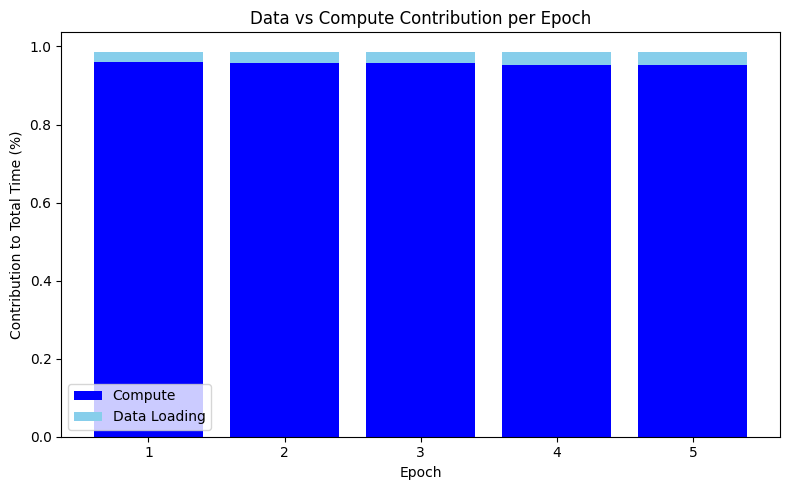

In [13]:
plt.figure(figsize=(8, 5))

epochs = [1, 2, 3, 4, 5]
# Stack bars
plt.bar(epochs, np.array(compute_time_arr)/np.array(epoch_time_arr), label='Compute', color='blue')
plt.bar(epochs, np.array(data_loading_time_arr)/np.array(epoch_time_arr), bottom=np.array(compute_time_arr)/np.array(epoch_time_arr), label='Data Loading', color='skyblue')

# 🧾 Annotate total time on top of each bar
# for i in range(len(epochs)):
#     plt.text(epochs[i], epoch_time_arr[i] + 0.3, f"{epoch_time_arr[i]:.1f}s",
#              ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xlabel('Epoch')
plt.ylabel('Contribution to Total Time (%)')
plt.title('Data vs Compute Contribution per Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
print(data_loading_time_arr, compute_time_arr, epoch_time_arr)

[1.1362109184265137, 1.230752944946289, 1.2963290214538574, 1.4094874858856201, 1.4818291664123535] [41.57454490661621, 42.04773426055908, 42.078760862350464, 42.1745662689209, 42.24960660934448] [43.28198599815369, 43.87720322608948, 43.954166650772095, 44.2338387966156, 44.39625382423401]


# C3

In [5]:
avg_epoch_time_arr = []
avg_data_time_arr = []

def train():
  with wandb.init(
      group="DataLoader Performance",
      config={
        "model_name": "distilbert-base-uncased",
        "max_len": 256, 
        "optimizer": "AdamW", 
        "batch_size": 32,
        "learning_rate": 1e-4,
        "epochs": 5, 
        "compile_mode": False
    }) as run:
      config = wandb.config
      run.name = f"lr{wandb.config.learning_rate}_bs{wandb.config.batch_size}_num_workers{config.num_workers}_C3"
      
      train_loader = DataLoader(tokenized["train"], batch_size=config.batch_size, shuffle=True, collate_fn=data_collator, num_workers=config.num_workers)
      test_loader = DataLoader(tokenized["test"], batch_size=config.batch_size, collate_fn=data_collator, num_workers=config.num_workers)
      model_name = "distilbert-base-uncased"
      model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
      model.to(device)
    
      optimizer = getattr(optim, config.optimizer)(model.parameters(), lr=config.learning_rate)
      print(f"---------start train: batch_size({config.batch_size}) lr({config.learning_rate}) num_workers({config.num_workers}) optimizer({config.optimizer})-----")
      train_loss = []
      train_accuracy = []
      test_accuracy = []
      data_loading_time_arr = []
      compute_time_arr = []
      epoch_time_arr = []
    
      for epoch in range(config.epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        data_loading_time = 0
        training_compute_time = 0
        total_epoch_time = 0
        start_data_loading = time.time()
        start_epoch_time = time.time()
        for batch in train_loader:
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
                "labels": batch["labels"].to(device),
            }
            torch.cuda.synchronize()
            end = time.time()
            data_loading_time +=  end - start_data_loading

            start_compute = time.time()
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
    
            torch.cuda.synchronize()
            end = time.time()
            training_compute_time += end - start_compute
    
            logits = outputs.logits
            preds = torch.argmax(logits, dim = 1)
            labels = batch["labels"].to(device)
            correct = (preds == labels).sum().item()
            total_correct += correct
            total_samples += len(labels)
            total_loss += loss.item()
    
            start_data_loading = time.time()
    
        end = time.time()
        total_epoch_time = end - start_epoch_time
    
        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_correct / total_samples
        train_loss.append(avg_loss)
        train_accuracy.append(avg_accuracy)
    
        model.eval()
        correct = 0
        total = 0
    
        with torch.no_grad():
            for batch in test_loader:
                inputs = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                }
                labels = batch["labels"].to(device)
    
                logits = model(**inputs).logits
                preds = torch.argmax(logits, dim=1)
    
                correct += (preds == labels).sum().item()
                total += labels.size(0)
    
        accuracy = correct / total
        test_accuracy.append(accuracy)
    
        wandb.log({"train/loss": train_loss,
                  "train/acc": avg_accuracy,
                  "test/acc": accuracy,
                  "data-loading time": data_loading_time,
                  "compute time": training_compute_time,
                  "total epoch time": total_epoch_time})
    
        data_loading_time_arr.append(data_loading_time)
        compute_time_arr.append(training_compute_time)
        epoch_time_arr.append(total_epoch_time)
        print(f"Epoch {epoch+1}/{config.epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}, data_loading time: {data_loading_time} \
                compute time: {training_compute_time} total epoch time: {total_epoch_time}")
        print(f"-------------------------------------------------------------------------------")
          
      avg_epoch_time_arr.append(sum(epoch_time_arr)/len(epoch_time_arr))
      avg_data_time_arr.append(sum(data_loading_time_arr)/len(data_loading_time_arr))
      

In [6]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        'num_workers': {'values': [0, 2, 4, 8]}
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)

wandb.agent(sweep_id, function=train, count=4)

wandb.finish()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 0vkzkara
Sweep URL: https://wandb.ai/kaimao-columbia-university/hpml-hw2-llm3/sweeps/0vkzkara


wandb: Agent Starting Run: qdnsf7w2 with config:
wandb: 	num_workers: 0
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ykmao1515 (kaimao-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(0) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.3068, Train Accuracy: 0.8698, Test Accuracy: 0.8830, data_loading time: 3.207254648208618                 compute time: 42.14731478691101 total epoch time: 45.59546518325806
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1683, Train Accuracy: 0.9381, Test Accuracy: 0.8951, data_loading time: 3.2103919982910156                 compute time: 42.06193470954895 total epoch time: 45.4927191734314
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0812, Train Accuracy: 0.9729, Test Accuracy: 0.8687, data_loading time: 3.2201642990112305                 compute time: 42.12448191642761 total epoch time: 45.56506967544556
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0552, Train Accuracy: 0.9818, Test Accuracy: 0.8828, data_loading time: 3.22

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 5/5, Loss: 0.0459, Train Accuracy: 0.9848, Test Accuracy: 0.8716, data_loading time: 3.2410035133361816                 compute time: 42.09473752975464 total epoch time: 45.55516505241394
-------------------------------------------------------------------------------


compute time,█▁▆▅▄
data-loading time,▁▂▄▅█
test/acc,▅█▁▅▂
total epoch time,█▁▆▅▅
train/acc,▁▅▇██
compute time,42.09474
data-loading time,3.241
test/acc,0.87164
total epoch time,45.55517
train/acc,0.98476


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l1vblfsg with config:
wandb: 	num_workers: 2
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(2) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.3109, Train Accuracy: 0.8689, Test Accuracy: 0.8999, data_loading time: 1.2844583988189697                 compute time: 42.11287546157837 total epoch time: 43.742393016815186
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1702, Train Accuracy: 0.9376, Test Accuracy: 0.8899, data_loading time: 1.1762325763702393                 compute time: 42.3264639377594 total epoch time: 43.83210825920105
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0917, Train Accuracy: 0.9681, Test Accuracy: 0.8803, data_loading time: 1.204374074935913                 compute time: 42.371110916137695 total epoch time: 43.91217541694641
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0529, Train Accuracy: 0.9822, Test Accuracy: 0.8798, data_loading time: 1.

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 5/5, Loss: 0.0373, Train Accuracy: 0.9870, Test Accuracy: 0.8713, data_loading time: 1.2159900665283203                 compute time: 42.38497710227966 total epoch time: 43.93879246711731
-------------------------------------------------------------------------------


compute time,▁▆▇██
data-loading time,█▂▃▁▄
test/acc,█▆▃▃▁
total epoch time,▁▄▇▆█
train/acc,▁▅▇██
compute time,42.38498
data-loading time,1.21599
test/acc,0.87132
total epoch time,43.93879
train/acc,0.98696


wandb: Agent Starting Run: m2kjq5pq with config:
wandb: 	num_workers: 4
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(4) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.3071, Train Accuracy: 0.8691, Test Accuracy: 0.8984, data_loading time: 1.2442965507507324                 compute time: 42.13042902946472 total epoch time: 43.72322225570679
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1745, Train Accuracy: 0.9359, Test Accuracy: 0.8892, data_loading time: 1.3141040802001953                 compute time: 42.362959146499634 total epoch time: 44.01722812652588
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0858, Train Accuracy: 0.9700, Test Accuracy: 0.8687, data_loading time: 1.32576584815979                 compute time: 42.40106701850891 total epoch time: 44.07692313194275
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0559, Train Accuracy: 0.9815, Test Accuracy: 0.8740, data_loading time: 1.2

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 5/5, Loss: 0.0428, Train Accuracy: 0.9855, Test Accuracy: 0.8688, data_loading time: 1.606079339981079                 compute time: 42.548943519592285 total epoch time: 44.54756450653076
-------------------------------------------------------------------------------


compute time,▁▅▆▅█
data-loading time,▁▂▃▁█
test/acc,█▆▁▂▁
total epoch time,▁▃▄▃█
train/acc,▁▅▇██
compute time,42.54894
data-loading time,1.60608
test/acc,0.86876
total epoch time,44.54756
train/acc,0.98552


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gdnlm5y5 with config:
wandb: 	num_workers: 8
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(8) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.3075, Train Accuracy: 0.8675, Test Accuracy: 0.8893, data_loading time: 1.3507966995239258                 compute time: 42.09671449661255 total epoch time: 43.81476807594299
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1637, Train Accuracy: 0.9393, Test Accuracy: 0.8778, data_loading time: 1.3857502937316895                 compute time: 42.364134788513184 total epoch time: 44.09523630142212
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0902, Train Accuracy: 0.9688, Test Accuracy: 0.8727, data_loading time: 1.3869707584381104                 compute time: 42.3030309677124 total epoch time: 44.046412229537964
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0525, Train Accuracy: 0.9830, Test Accuracy: 0.8776, data_loading time: 1

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 5/5, Loss: 0.0442, Train Accuracy: 0.9851, Test Accuracy: 0.8731, data_loading time: 1.389526605606079                 compute time: 42.33134984970093 total epoch time: 44.03655123710632
-------------------------------------------------------------------------------


compute time,▁█▆▇▇
data-loading time,▁▇█▃█
test/acc,█▃▁▃▁
total epoch time,▁█▇▇▇
train/acc,▁▅▇██
compute time,42.33135
data-loading time,1.38953
test/acc,0.87312
total epoch time,44.03655
train/acc,0.98508


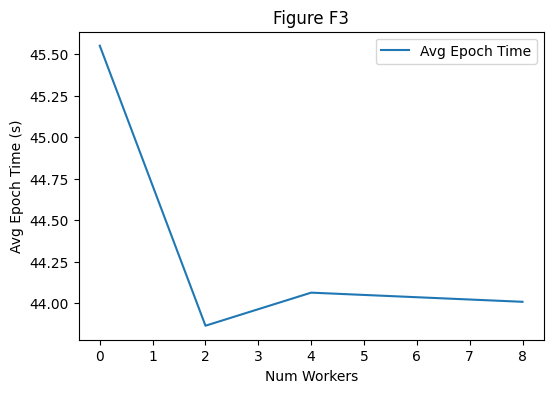

In [9]:
plt.figure(figsize=(6, 4))

num_workers = [0, 2, 4, 8]
plt.plot(num_workers, avg_epoch_time_arr, label='Avg Epoch Time')
plt.xlabel('Num Workers')
plt.ylabel('Avg Epoch Time (s)')
plt.title('Figure F3')
plt.legend()
plt.show()

In [10]:
print(avg_epoch_time_arr, avg_data_time_arr)

[45.55211009979248, 43.86295328140259, 44.062462377548215, 44.007269287109374] [3.220819854736328, 1.2093932151794433, 1.3516160488128661, 1.3752715110778808]


In [11]:
wandb.termlog("Manually resetting W&B backend...")
wandb.finish()
wandb.teardown()

# Clear the global run object
wandb.run = None
wandb._thread_local = None

wandb: Manually resetting W&B backend...


In [12]:

wandb.init(project=project_name, name=f"C3 result", group = "DataLoader Performance")

records = []
for i in range(4):
    records.append({
        "num_workers": num_workers[i],
        "Avg Epoch Time": avg_epoch_time_arr[i],
        "Avg Data Time": avg_data_time_arr[i],
        "Batch Size": 32
    })

print(records)
df = pd.DataFrame(records)
wandb.log({"C3_result":wandb.Table(dataframe=df)})
wandb.finish()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[{'num_workers': 0, 'Avg Epoch Time': 45.55211009979248, 'Avg Data Time': 3.220819854736328, 'Batch Size': 32}, {'num_workers': 2, 'Avg Epoch Time': 43.86295328140259, 'Avg Data Time': 1.2093932151794433, 'Batch Size': 32}, {'num_workers': 4, 'Avg Epoch Time': 44.062462377548215, 'Avg Data Time': 1.3516160488128661, 'Batch Size': 32}, {'num_workers': 8, 'Avg Epoch Time': 44.007269287109374, 'Avg Data Time': 1.3752715110778808, 'Batch Size': 32}]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


# C4

In [5]:
wandb.termlog("Manually resetting W&B backend...")
wandb.finish()
wandb.teardown()

# Clear the global run object
wandb.run = None
wandb._thread_local = None

wandb: Manually resetting W&B backend...


In [ ]:
import torch.profiler as profiler

for num_workers in [2]:
    wandb.init(project=project_name, name=f"bs32_lr1e-4num_works{num_workers}_C4", group = "PyTorch Profiler")

    wandb.config.update({
        "model_name": "distilbert-base-uncased",
        "max_len": 256,
        "batch_size": 32,
        "lr": 1e-4,
        "optimizer": "AdamW",
        "num_workers": num_workers,
        "epochs": 2,
        "compile_mode": False
    })
    config = wandb.config
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_name = "distilbert-base-uncased"
    model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=config.lr)
    
    train_loader = DataLoader(tokenized["train"], batch_size=config.batch_size, shuffle=True, collate_fn=data_collator, num_workers=config.num_workers)
    test_loader = DataLoader(tokenized["test"], batch_size=config.batch_size, collate_fn=data_collator, num_workers=config.num_workers)
    print(f"config num:{config.num_workers}")
    
    train_loss = []
    train_accuracy = []
    test_accuracy = []
    
    with profiler.profile(
        activities=[profiler.ProfilerActivity.CPU, profiler.ProfilerActivity.CUDA],
        # on_trace_ready=torch.profiler.tensorboard_trace_handler(f"./profiler_logs_num_wokers{num_workers}"),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
    ) as prof:
        for epoch in range(config.epochs):
            model.train()
            total_loss = 0
            total_correct = 0
            total_samples = 0
            for batch in tqdm(train_loader):
                optimizer.zero_grad()
    
                with profiler.record_function("data_loading"):
                    inputs = {
                        "input_ids": batch["input_ids"].to(device),
                        "attention_mask": batch["attention_mask"].to(device),
                        "labels": batch["labels"].to(device),
                    }
    
                with profiler.record_function("forward"):
                    outputs = model(**inputs)
    
                with profiler.record_function("backward"):
                    loss = outputs.loss
                    loss.backward()
    
                with profiler.record_function("optimizer"):
                    optimizer.step()
    
                logits = outputs.logits
                preds = torch.argmax(logits, dim = 1)
                labels = batch["labels"].to(device)
                correct = (preds == labels).sum().item()
                total_correct += correct
                total_samples += len(labels)
                total_loss += loss.item()
    
            avg_loss = total_loss / len(train_loader)
            avg_accuracy = total_correct / total_samples
            train_loss.append(avg_loss)
            train_accuracy.append(avg_accuracy)
    
            model.eval()
            correct = 0
            total = 0
    
            with torch.no_grad():
                for batch in test_loader:
                    inputs = {
                        "input_ids": batch["input_ids"].to(device),
                        "attention_mask": batch["attention_mask"].to(device),
                    }
                    labels = batch["labels"].to(device)
    
                    logits = model(**inputs).logits
                    preds = torch.argmax(logits, dim=1)
    
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)
    
            accuracy = correct / total
            test_accuracy.append(accuracy)
            print(f"Epoch {epoch+1}/{config.epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}")

            wandb.log({"train/loss": train_loss,
              "train/acc": avg_accuracy,
              "test/acc": accuracy,
              "data-loading time": data_loading_time,
              "compute time": training_compute_time,
              "total epoch time": total_epoch_time})

            prof.step()

    # print(prof.is_active(), prof.profiler)
    torch.cuda.synchronize()
    with open(f"profile_C4_num_workers_{num_workers}_result.txt", "w") as f:
        print(f"\n===== CPU Profiling num_workers {num_workers}=====",file=f)
        print(prof.key_averages().table(
            sort_by="self_cpu_time_total",  # or "cpu_time_total"
            row_limit=10
        ), file=f)
        
        # ✅ Print GPU-focused results
        print(f"\n===== GPU Profiling num_workers {num_workers}=====",file=f)
        print(prof.key_averages().table(
            sort_by="self_cuda_time_total",  # or "cuda_time_total"
            row_limit=10
        ), file=f)
    wandb.finish()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config num:2


100%|██████████| 782/782 [00:50<00:00, 15.54it/s]


In [ ]:
# Epoch 1/1, Loss: 0.3067, Train Accuracy: 0.8695, Test Accuracy: 0.9015

# ===== CPU Profiling =====
# -------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
#                                                    Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
# -------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
#                                   cudaStreamSynchronize        28.90%       22.115s        28.90%       22.115s       2.357ms       0.000us         0.00%       0.000us       0.000us           0 B           0 B           0 B           0 B          9384  
#                                                backward        21.53%       16.479s        21.75%       16.647s      21.287ms       0.000us         0.00%     591.550us       0.756us     -73.31 KB     -73.28 KB   -1638.43 GB   -1638.27 GB           782  
# enumerate(DataLoader)#_MultiProcessingDataLoaderIter...         7.29%        5.579s         7.34%        5.617s       3.587ms       0.000us         0.00%       0.000us       0.000us     195.69 MB     195.50 MB           0 B           0 B          1566  
#                                                 forward         4.79%        3.669s        12.61%        9.647s      12.336ms       0.000us         0.00%       15.294s      19.557ms      73.31 KB      -3.05 KB    1836.28 GB    -381.56 GB           782  
#                               Optimizer.step#AdamW.step         4.69%        3.586s         7.71%        5.903s       7.548ms       0.000us         0.00%        2.779s       3.554ms         416 B      -3.05 KB     510.83 MB    -195.05 GB           782  
#                                        cudaLaunchKernel         2.76%        2.116s         2.80%        2.145s       8.673us       0.000us         0.00%     798.937us       0.003us           0 B           0 B           0 B           0 B        247301  
#                                             aten::addmm         2.66%        2.035s         3.68%        2.814s      47.355us       26.199s        46.90%       26.201s     440.854us           0 B           0 B    1977.68 GB    1977.68 GB         59432  
#                                                aten::mm         2.58%        1.973s         3.70%        2.829s      47.609us       16.342s        29.25%       16.342s     274.969us           0 B           0 B    1117.21 GB    1117.21 GB         59432  
#                                         aten::transpose         1.30%     991.595ms         1.78%        1.359s       4.324us       0.000us         0.00%       0.000us       0.000us           0 B           0 B           0 B           0 B        314364  
#                                               aten::sum         1.29%     985.262ms         1.93%        1.476s      40.154us     687.082ms         1.23%     688.771ms      18.740us           0 B           0 B       2.41 GB       2.41 GB         36754  
#                                          cuLaunchKernel         1.23%     939.936ms         1.23%     943.680ms       7.992us       0.000us         0.00%     463.166us       0.004us           0 B           0 B           0 B           0 B        118077  
#                                             aten::empty         1.17%     896.615ms         1.17%     896.615ms       5.209us       0.000us         0.00%       0.000us       0.000us     469.87 KB     469.87 KB    1646.27 GB    1646.27 GB        172139  
#                                         cudaMemsetAsync         0.98%     750.617ms         0.98%     750.617ms       5.189us       0.000us         0.00%       0.000us       0.000us           0 B           0 B           0 B           0 B        144667  
#     autograd::engine::evaluate_function: AddmmBackward0         0.92%     701.966ms         7.92%        6.064s     204.069us       0.000us         0.00%       16.950s     570.402us           0 B           0 B    -439.20 GB   -1556.54 GB         29716  
#                                              aten::view         0.88%     670.713ms         0.88%     670.713ms       2.171us       0.000us         0.00%       0.000us       0.000us           0 B           0 B           0 B           0 B        308890  
#                                     aten::empty_strided         0.81%     622.397ms         0.81%     622.397ms       5.928us       0.000us         0.00%       0.000us       0.000us           0 B           0 B     372.71 GB     372.71 GB        104996  
#      autograd::engine::evaluate_function: ViewBackward0         0.76%     581.743ms         2.12%        1.623s      21.394us       0.000us         0.00%     360.275ms       4.750us           0 B           0 B    -439.45 GB    -439.45 GB         75854  
#                                                 aten::t         0.75%     573.036ms         1.77%        1.357s       7.609us       0.000us         0.00%       0.000us       0.000us           0 B           0 B           0 B           0 B        178296  
#                                          AddmmBackward0         0.65%     495.818ms         5.32%        4.070s     136.957us       0.000us         0.00%       16.342s     549.938us           0 B           0 B    1117.21 GB           0 B         29716  
#                                            aten::linear         0.64%     489.399ms         5.33%        4.080s      68.647us       0.000us         0.00%       26.201s     440.854us           0 B           0 B    1977.68 GB     -25.00 MB         59432  
# -------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
# Self CPU time total: 76.528s
# Self CUDA time total: 55.861s


# ===== GPU Profiling =====
# -------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
#                                                    Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
# -------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
#                                             aten::addmm         2.66%        2.035s         3.68%        2.814s      47.355us       26.199s        46.90%       26.201s     440.854us           0 B           0 B    1977.68 GB    1977.68 GB         59432  
# void cutlass::Kernel2<cutlass_80_simt_sgemm_256x128_...         0.00%       0.000us         0.00%       0.000us       0.000us       19.288s        34.53%       19.288s     411.646us           0 B           0 B           0 B           0 B         46856  
#                                                 forward         0.00%       0.000us         0.00%       0.000us       0.000us       16.371s        29.31%       16.371s      20.935ms           0 B           0 B           0 B           0 B           782  
#                                                aten::mm         2.58%        1.973s         3.70%        2.829s      47.609us       16.342s        29.25%       16.342s     274.969us           0 B           0 B    1117.21 GB    1117.21 GB         59432  
# void cutlass::Kernel2<cutlass_80_simt_sgemm_256x128_...         0.00%       0.000us         0.00%       0.000us       0.000us        8.550s        15.31%        8.550s     303.701us           0 B           0 B           0 B           0 B         28152  
# void cutlass::Kernel2<cutlass_80_simt_sgemm_128x256_...         0.00%       0.000us         0.00%       0.000us       0.000us        6.854s        12.27%        6.854s     725.749us           0 B           0 B           0 B           0 B          9444  
# void cutlass::Kernel2<cutlass_80_simt_sgemm_128x128_...         0.00%       0.000us         0.00%       0.000us       0.000us        4.933s         8.83%        4.933s     525.664us           0 B           0 B           0 B           0 B          9384  
#                     aten::_efficient_attention_backward         0.34%     258.509ms         1.37%        1.050s     223.832us        3.802s         6.81%        3.979s     848.058us           0 B           0 B     329.59 GB    -223.27 GB          4692  
# fmha_cutlassB_f32_aligned_64x64_k64_dropout_sm80(PyT...         0.00%       0.000us         0.00%       0.000us       0.000us        3.802s         6.81%        3.802s     810.373us           0 B           0 B           0 B           0 B          4692  
#                               Optimizer.step#AdamW.step         0.00%       0.000us         0.00%       0.000us       0.000us        2.817s         5.04%        2.817s       3.602ms           0 B           0 B           0 B           0 B           782  
# void cutlass::Kernel2<cutlass_80_simt_sgemm_128x64_8...         0.00%       0.000us         0.00%       0.000us       0.000us        2.804s         5.02%        2.804s     149.427us           0 B           0 B           0 B           0 B         18768  
#                      aten::_efficient_attention_forward         0.23%     179.541ms         0.58%     441.900ms      47.091us        2.332s         4.17%        2.332s     248.496us     146.62 KB       3.66 KB     221.44 GB           0 B          9384  
# fmha_cutlassF_f32_aligned_64x64_rf_sm80(PyTorchMemEf...         0.00%       0.000us         0.00%       0.000us       0.000us        2.332s         4.17%        2.332s     248.523us           0 B           0 B           0 B           0 B          9383  
#                                              aten::gelu         0.19%     144.642ms         0.28%     216.680ms      23.090us        1.009s         1.81%        1.009s     107.507us           0 B           0 B     878.91 GB     878.91 GB          9384  
# void at::native::vectorized_elementwise_kernel<4, at...         0.00%       0.000us         0.00%       0.000us       0.000us        1.009s         1.81%        1.009s     107.495us           0 B           0 B           0 B           0 B          9384  
#                                     aten::gelu_backward         0.11%      83.091ms         0.18%     137.218ms      29.245us     727.013ms         1.30%     727.013ms     154.947us           0 B           0 B     439.45 GB     439.45 GB          4692  
# void at::native::vectorized_elementwise_kernel<4, at...         0.00%       0.000us         0.00%       0.000us       0.000us     727.013ms         1.30%     727.013ms     154.947us           0 B           0 B           0 B           0 B          4692  
# void at::native::vectorized_elementwise_kernel<4, at...         0.00%       0.000us         0.00%       0.000us       0.000us     701.805ms         1.26%     701.805ms      18.697us           0 B           0 B           0 B           0 B         37535  
#                                               aten::sum         1.29%     985.262ms         1.93%        1.476s      40.154us     687.082ms         1.23%     688.771ms      18.740us           0 B           0 B       2.41 GB       2.41 GB         36754  
# void at::native::reduce_kernel<128, 4, at::native::R...         0.00%       0.000us         0.00%       0.000us       0.000us     590.090ms         1.06%     590.090ms      19.858us           0 B           0 B           0 B           0 B         29716  
# -------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
# Self CPU time total: 76.528s
# Self CUDA time total: 55.861s

AttributeError: 'FunctionEventAvg' object has no attribute 'cuda_time_total'

# C6


In [39]:
avg_epoch_time = []
final_test_accuracy = []
avg_train_accuracy = []
final_train_loss = []
def train_C6():
  with wandb.init(
    group="Hyperparameter Sensitivity",
    config={
        "model_name": "distilbert-base-uncased",
        "max_len": 256, 
        "optimizer": "AdamW", 
        "num_workers": 2,
        "epochs": 5, 
        "compile_mode": False
    }) as run:
      config = wandb.config
      run.name = f"lr{wandb.config.learning_rate}_bs{wandb.config.batch_size}_C6"
      
      train_loader = DataLoader(tokenized["train"], batch_size=config.batch_size, shuffle=True, collate_fn=data_collator, num_workers=config.num_workers)
      test_loader = DataLoader(tokenized["test"], batch_size=config.batch_size, collate_fn=data_collator, num_workers=config.num_workers)
      model_name = "distilbert-base-uncased"
      model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
      model.to(device)
    
      optimizer = getattr(optim, config.optimizer)(model.parameters(), lr=config.learning_rate)
      print(f"---------start train: batch_size({config.batch_size}) lr({config.learning_rate}) num_workers({config.num_workers}) optimizer({config.optimizer})-----")
      train_loss = []
      train_accuracy = []
      test_accuracy = []
      data_loading_time_arr = []
      compute_time_arr = []
      epoch_time_arr = []
      sum_train_accuracy = 0
      avg_loss = 0
    
      for epoch in range(config.epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        data_loading_time = 0
        training_compute_time = 0
        total_epoch_time = 0
        start_data_loading = time.time()
        start_epoch_time = time.time()
        for batch in train_loader:
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
                "labels": batch["labels"].to(device),
            }
            torch.cuda.synchronize()
            end = time.time()
            data_loading_time +=  end - start_data_loading

            start_compute = time.time()
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
    
            torch.cuda.synchronize()
            end = time.time()
            training_compute_time += end - start_compute
    
            logits = outputs.logits
            preds = torch.argmax(logits, dim = 1)
            labels = batch["labels"].to(device)
            correct = (preds == labels).sum().item()
            total_correct += correct
            total_samples += len(labels)
            total_loss += loss.item()
    
            start_data_loading = time.time()
    
        end = time.time()
        total_epoch_time = end - start_epoch_time
    
        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_correct / total_samples
        train_loss.append(avg_loss)
        train_accuracy.append(avg_accuracy)
        sum_train_accuracy += avg_accuracy
    
        model.eval()
        correct = 0
        total = 0
    
        with torch.no_grad():
            for batch in test_loader:
                inputs = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                }
                labels = batch["labels"].to(device)
    
                logits = model(**inputs).logits
                preds = torch.argmax(logits, dim=1)
    
                correct += (preds == labels).sum().item()
                total += labels.size(0)
    
        accuracy = correct / total
        test_accuracy.append(accuracy)
    
        wandb.log({"train/loss": train_loss,
                  "train/acc": avg_accuracy,
                  "test/acc": accuracy,
                  "data-loading time": data_loading_time,
                  "compute time": training_compute_time,
                  "total epoch time": total_epoch_time})
    
        data_loading_time_arr.append(data_loading_time)
        compute_time_arr.append(training_compute_time)
        epoch_time_arr.append(total_epoch_time)
        print(f"Epoch {epoch+1}/{config.epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}, data_loading time: {data_loading_time} \
                compute time: {training_compute_time} total epoch time: {total_epoch_time}")
        print(f"-------------------------------------------------------------------------------")
        
      avg_epoch_time.append({"lr":config.learning_rate, "batch_size":config.batch_size, "avg_epoch_time":sum(epoch_time_arr)/len(epoch_time_arr)})
      avg_train_accuracy.append({"lr":config.learning_rate, "batch_size":config.batch_size, "avg_train_accuracy":sum_train_accuracy/config.epochs})
      final_train_loss.append({"lr":config.learning_rate, "batch_size":config.batch_size, "final_train_loss":avg_loss})

      model.eval()
      correct = 0
      total = 0
    
      with torch.no_grad():
          for batch in test_loader:
              inputs = {
                  "input_ids": batch["input_ids"].to(device),
                  "attention_mask": batch["attention_mask"].to(device),
              }
              labels = batch["labels"].to(device)
    
              logits = model(**inputs).logits
              preds = torch.argmax(logits, dim=1)
    
              correct += (preds == labels).sum().item()
              total += labels.size(0)
    
      accuracy = correct / total
      final_test_accuracy.append({"lr":config.learning_rate, "batch_size":config.batch_size, "final_test_accuracy":accuracy})

In [40]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        'batch_size': {'values': [16, 32, 64]},
        'learning_rate': {'values': [5e-5, 1e-4, 5e-4]}
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)

wandb.agent(sweep_id, function=train_C6, count=9)

Create sweep with ID: ol99ftwm
Sweep URL: https://wandb.ai/kaimao-columbia-university/hpml-hw2-llm3/sweeps/ol99ftwm


wandb: Agent Starting Run: p1bqe09h with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 5e-05
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(16) lr(5e-05) num_workers(2) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.2918, Train Accuracy: 0.8799, Test Accuracy: 0.8775, data_loading time: 3.3743536472320557                 compute time: 48.26205515861511 total epoch time: 52.288145780563354
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1603, Train Accuracy: 0.9405, Test Accuracy: 0.9058, data_loading time: 3.3897156715393066                 compute time: 48.5977144241333 total epoch time: 52.78198218345642
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0862, Train Accuracy: 0.9705, Test Accuracy: 0.8950, data_loading time: 2.3981313705444336                 compute time: 47.99050521850586 total epoch time: 51.00476956367493
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0483, Train Accuracy: 0.9839, Test Accuracy: 0.8954, data_loading time: 3.0

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▅█▂▆▁
data-loading time,██▂▆▁
test/acc,▁█▅▅▃
total epoch time,▆█▂▆▁
train/acc,▁▅▇██
compute time,47.90713
data-loading time,2.29068
test/acc,0.88592
total epoch time,50.73609
train/acc,0.98768


wandb: Agent Starting Run: 4j2skc6g with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0001
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(16) lr(0.0001) num_workers(2) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.3212, Train Accuracy: 0.8652, Test Accuracy: 0.8912, data_loading time: 2.64289927482605                 compute time: 48.116403341293335 total epoch time: 51.40435862541199
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1931, Train Accuracy: 0.9298, Test Accuracy: 0.8748, data_loading time: 3.5315537452697754                 compute time: 48.540836811065674 total epoch time: 52.75370383262634
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.1134, Train Accuracy: 0.9611, Test Accuracy: 0.8567, data_loading time: 2.744121789932251                 compute time: 48.2916259765625 total epoch time: 51.64160513877869
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0717, Train Accuracy: 0.9768, Test Accuracy: 0.8475, data_loading time: 2.09

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▄█▅▁▄
data-loading time,▄█▄▁▄
test/acc,█▆▄▂▁
total epoch time,▄█▅▁▄
train/acc,▁▅▇██
compute time,48.15519
data-loading time,2.65506
test/acc,0.83656
total epoch time,51.45206
train/acc,0.98164


wandb: Agent Starting Run: u6bq0oxd with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0005
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(16) lr(0.0005) num_workers(2) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.6979, Train Accuracy: 0.4982, Test Accuracy: 0.5000, data_loading time: 2.0696771144866943                 compute time: 47.677361249923706 total epoch time: 50.26917052268982
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.6939, Train Accuracy: 0.4967, Test Accuracy: 0.5000, data_loading time: 2.4066808223724365                 compute time: 48.00001931190491 total epoch time: 51.00696659088135
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.6938, Train Accuracy: 0.4936, Test Accuracy: 0.5000, data_loading time: 2.3085412979125977                 compute time: 47.86158561706543 total epoch time: 50.7403998374939
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.6935, Train Accuracy: 0.4949, Test Accuracy: 0.5000, data_loading time: 2.

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁▇▄█▂
data-loading time,▁▄▃█▂
test/acc,▁▁▁▁▁
total epoch time,▁▅▃█▂
train/acc,█▆▁▃▂
compute time,47.7543
data-loading time,2.22308
test/acc,0.5
total epoch time,50.47783
train/acc,0.49428


wandb: Agent Starting Run: x80pl9r7 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 5e-05
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(5e-05) num_workers(2) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.2823, Train Accuracy: 0.8813, Test Accuracy: 0.9020, data_loading time: 1.380310297012329                 compute time: 42.451884508132935 total epoch time: 44.200751543045044
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1539, Train Accuracy: 0.9419, Test Accuracy: 0.8943, data_loading time: 1.2978613376617432                 compute time: 42.62789964675903 total epoch time: 44.28197240829468
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0786, Train Accuracy: 0.9742, Test Accuracy: 0.9085, data_loading time: 1.2501893043518066                 compute time: 42.524516344070435 total epoch time: 44.11564493179321
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0447, Train Accuracy: 0.9847, Test Accuracy: 0.9077, data_loading time: 1

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁█▄▃▄
data-loading time,█▅▃▂▁
test/acc,▅▁██▇
total epoch time,▆█▃▁▁
train/acc,▁▅▇██
compute time,42.52325
data-loading time,1.1968
test/acc,0.90592
total epoch time,44.06284
train/acc,0.99096


wandb: Agent Starting Run: wvw3j86f with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0001
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(2) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.3062, Train Accuracy: 0.8685, Test Accuracy: 0.9012, data_loading time: 1.5294194221496582                 compute time: 42.4873571395874 total epoch time: 44.40516996383667
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1694, Train Accuracy: 0.9359, Test Accuracy: 0.8965, data_loading time: 1.2967138290405273                 compute time: 42.53153419494629 total epoch time: 44.18459892272949
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0856, Train Accuracy: 0.9698, Test Accuracy: 0.8786, data_loading time: 1.2219390869140625                 compute time: 42.48101878166199 total epoch time: 44.04977250099182
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0557, Train Accuracy: 0.9814, Test Accuracy: 0.8717, data_loading time: 1.7

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▂▃▂█▁
data-loading time,▅▂▁█▂
test/acc,█▇▄▃▁
total epoch time,▄▂▁█▁
train/acc,▁▅▇██
compute time,42.44294
data-loading time,1.2599
test/acc,0.86356
total epoch time,44.05166
train/acc,0.98552


wandb: Agent Starting Run: rafrijva with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0005) num_workers(2) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.6957, Train Accuracy: 0.5024, Test Accuracy: 0.5000, data_loading time: 1.2267851829528809                 compute time: 42.107866525650024 total epoch time: 43.68450331687927
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.6940, Train Accuracy: 0.4998, Test Accuracy: 0.5000, data_loading time: 1.2665433883666992                 compute time: 42.39352369308472 total epoch time: 44.01552724838257
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.6936, Train Accuracy: 0.4962, Test Accuracy: 0.5000, data_loading time: 1.2540805339813232                 compute time: 42.26508092880249 total epoch time: 43.836198806762695
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.6932, Train Accuracy: 0.4997, Test Accuracy: 0.5000, data_loading time: 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁▇▄█▄
data-loading time,▁▂▂█▂
test/acc,▁▁▁▁▁
total epoch time,▁▄▃█▃
train/acc,█▆▃▆▁
compute time,42.25425
data-loading time,1.28138
test/acc,0.5
total epoch time,43.88601
train/acc,0.4936


wandb: Agent Starting Run: e5syj5rl with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 5e-05
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(64) lr(5e-05) num_workers(2) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.2871, Train Accuracy: 0.8793, Test Accuracy: 0.9125, data_loading time: 0.7448124885559082                 compute time: 40.29151630401611 total epoch time: 41.27488875389099
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1590, Train Accuracy: 0.9407, Test Accuracy: 0.9059, data_loading time: 0.7579576969146729                 compute time: 40.61621165275574 total epoch time: 41.60559034347534
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0764, Train Accuracy: 0.9744, Test Accuracy: 0.8921, data_loading time: 0.7468810081481934                 compute time: 40.65260195732117 total epoch time: 41.637370586395264
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0396, Train Accuracy: 0.9878, Test Accuracy: 0.8986, data_loading time: 0.

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁▇██▇
data-loading time,▆█▇▁▇
test/acc,█▆▁▃▇
total epoch time,▁▇█▇█
train/acc,▁▅▇██
compute time,40.6347
data-loading time,0.75024
test/acc,0.90896
total epoch time,41.62162
train/acc,0.98864


wandb: Agent Starting Run: 733fjja3 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(64) lr(0.0001) num_workers(2) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.2942, Train Accuracy: 0.8734, Test Accuracy: 0.9015, data_loading time: 0.7395803928375244                 compute time: 40.36083436012268 total epoch time: 41.32348442077637
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.1583, Train Accuracy: 0.9411, Test Accuracy: 0.9043, data_loading time: 0.7551038265228271                 compute time: 40.66460466384888 total epoch time: 41.65313982963562
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.0768, Train Accuracy: 0.9735, Test Accuracy: 0.9009, data_loading time: 0.744041919708252                 compute time: 40.637380838394165 total epoch time: 41.61850595474243
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.0468, Train Accuracy: 0.9836, Test Accuracy: 0.8866, data_loading time: 0.

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁█▇██
data-loading time,▁█▃▂▂
test/acc,██▇▅▁
total epoch time,▁█▇▇▇
train/acc,▁▅▇██
compute time,40.64794
data-loading time,0.74093
test/acc,0.86296
total epoch time,41.62572
train/acc,0.98972


wandb: Agent Starting Run: xxz1nhu5 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0005
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(64) lr(0.0005) num_workers(2) optimizer(AdamW)-----
Epoch 1/5, Loss: 0.6968, Train Accuracy: 0.5070, Test Accuracy: 0.5000, data_loading time: 0.7187292575836182                 compute time: 40.23909902572632 total epoch time: 41.192381620407104
-------------------------------------------------------------------------------
Epoch 2/5, Loss: 0.6941, Train Accuracy: 0.4930, Test Accuracy: 0.5000, data_loading time: 0.7286243438720703                 compute time: 40.48895764350891 total epoch time: 41.44946217536926
-------------------------------------------------------------------------------
Epoch 3/5, Loss: 0.6933, Train Accuracy: 0.5028, Test Accuracy: 0.5000, data_loading time: 0.7374804019927979                 compute time: 40.398369550704956 total epoch time: 41.36970257759094
-------------------------------------------------------------------------------
Epoch 4/5, Loss: 0.6934, Train Accuracy: 0.5006, Test Accuracy: 0.5000, data_loading time: 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁█▅▄▃
data-loading time,▁▄▇▄█
test/acc,▁▁▁▁▁
total epoch time,▁█▆▄▃
train/acc,█▁▆▅▄
compute time,40.31126
data-loading time,0.73928
test/acc,0.5
total epoch time,41.27952
train/acc,0.49956


In [41]:
def draw_heatmap(data, data_name):
    batch_sizes = [16, 32, 64]
    learning_rates = [5e-5, 1e-4, 5e-4]
    extracted_data = [[0] * 3 for _ in range(3)]
    for i in range(3):
        for j in range(3):
            extracted_data[i][j] = data[i * len(learning_rates) +  j][data_name]

    fig, ax = plt.subplots(figsize=(6, 4))
    im = ax.imshow(extracted_data, cmap="viridis", origin="lower")

    # Label axes
    ax.set_xticks(np.arange(len(learning_rates)))
    ax.set_yticks(np.arange(len(batch_sizes)))
    ax.set_xticklabels([f"{lr:.0e}" for lr in learning_rates])
    ax.set_yticklabels(batch_sizes)

    ax.set_xlabel("Learning Rate")
    ax.set_ylabel("Batch Size")
    ax.set_title(f"Figure F6: {data_name} (seconds)")

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(f"{data_name} (s)")

    # Annotate values on heatmap
    for i in range(len(batch_sizes)):
        for j in range(len(learning_rates)):
            ax.text(j, i, f"{extracted_data[i][j]:.4f}",
                    ha="center", va="center", color="white", fontsize=9)

    plt.tight_layout()
    plt.show()


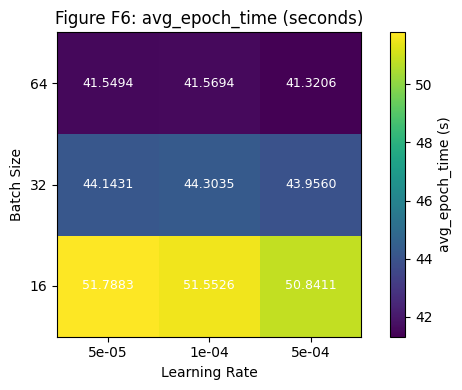

In [42]:
draw_heatmap(avg_epoch_time, "avg_epoch_time")

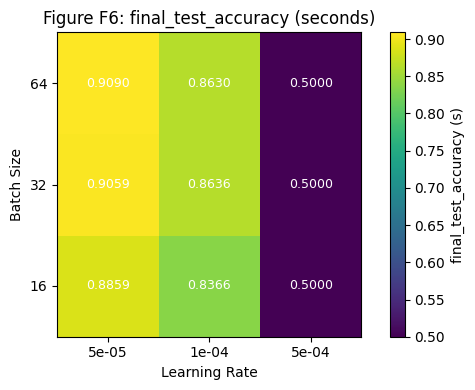

In [43]:
draw_heatmap(final_test_accuracy, "final_test_accuracy")

In [44]:
print(avg_epoch_time, final_train_loss, avg_train_accuracy, final_test_accuracy)

[{'lr': 5e-05, 'batch_size': 16, 'avg_epoch_time': 51.78834919929504}, {'lr': 0.0001, 'batch_size': 16, 'avg_epoch_time': 51.55258145332336}, {'lr': 0.0005, 'batch_size': 16, 'avg_epoch_time': 50.841063022613525}, {'lr': 5e-05, 'batch_size': 32, 'avg_epoch_time': 44.143100595474245}, {'lr': 0.0001, 'batch_size': 32, 'avg_epoch_time': 44.30346474647522}, {'lr': 0.0005, 'batch_size': 32, 'avg_epoch_time': 43.955963706970216}, {'lr': 5e-05, 'batch_size': 64, 'avg_epoch_time': 41.54936318397522}, {'lr': 0.0001, 'batch_size': 64, 'avg_epoch_time': 41.56937665939331}, {'lr': 0.0005, 'batch_size': 64, 'avg_epoch_time': 41.320552349090576}] [{'lr': 5e-05, 'batch_size': 16, 'final_train_loss': 0.03710960883797508}, {'lr': 0.0001, 'batch_size': 16, 'final_train_loss': 0.05841411100556003}, {'lr': 0.0005, 'batch_size': 16, 'final_train_loss': 0.6938722445960237}, {'lr': 5e-05, 'batch_size': 32, 'final_train_loss': 0.027467254890471964}, {'lr': 0.0001, 'batch_size': 32, 'final_train_loss': 0.04203

In [50]:
wandb.termlog("Manually resetting W&B backend...")
wandb.finish()
wandb.teardown()

# Clear the global run object
wandb.run = None
wandb._thread_local = None

wandb: Manually resetting W&B backend...


In [51]:
wandb.init(project=project_name, group="Hyperparameter Sensitivity", name="C6 result")

records = []
for i in range(len(avg_epoch_time)):
    records.append({
        "Batch Size": avg_epoch_time[i]["batch_size"],
        "LR": avg_epoch_time[i]["lr"],
        "Avg Epoch Time": avg_epoch_time[i]["avg_epoch_time"],
        "Final Train Loss": final_train_loss[i]["final_train_loss"],
        "Train Acc": avg_train_accuracy[i]["avg_train_accuracy"],
        "Test Acc": final_test_accuracy[i]["final_test_accuracy"]
    })

df = pd.DataFrame(records)
print(records)
wandb.log({"C6_result":wandb.Table(dataframe=df)})
wandb.finish()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[{'Batch Size': 16, 'LR': 5e-05, 'Avg Epoch Time': 51.78834919929504, 'Final Train Loss': 0.03710960883797508, 'Train Acc': 0.9524800000000001, 'Test Acc': 0.88592}, {'Batch Size': 16, 'LR': 0.0001, 'Avg Epoch Time': 51.55258145332336, 'Final Train Loss': 0.05841411100556003, 'Train Acc': 0.942896, 'Test Acc': 0.83656}, {'Batch Size': 16, 'LR': 0.0005, 'Avg Epoch Time': 50.841063022613525, 'Final Train Loss': 0.6938722445960237, 'Train Acc': 0.49554400000000004, 'Test Acc': 0.5}, {'Batch Size': 32, 'LR': 5e-05, 'Avg Epoch Time': 44.143100595474245, 'Final Train Loss': 0.027467254890471964, 'Train Acc': 0.9546240000000001, 'Test Acc': 0.90592}, {'Batch Size': 32, 'LR': 0.0001, 'Avg Epoch Time': 44.30346474647522, 'Final Train Loss': 0.04203675107082443, 'Train Acc': 0.9482240000000001, 'Test Acc': 0.86356}, {'Batch Size': 32, 'LR': 0.0005, 'Avg Epoch Time': 43.955963706970216, 'Final Train Loss': 0.6932823576433275, 'Train Acc': 0.49835199999999996, 'Test Acc': 0.5}, {'Batch Size': 64, 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


# C7

In [51]:
avg_epoch_time = []
final_test_accuracy = []
avg_train_accuracy = []
final_train_loss = []
def train_C7():
  with wandb.init(
    group="Optimizer Comparison",
    config={
        "model_name": "distilbert-base-uncased",
        "max_len": 256, 
        "batch_size": 32,
        "learning_rate": 1e-4,
        "num_workers": 2,
        "epochs": 5, 
        "compile_mode": False
    }) as run:
      config = wandb.config

      run.name = f"lr{wandb.config.learning_rate}_bs{wandb.config.batch_size}_optimizer{wandb.config.optimizer}_C7"
      train_loader = DataLoader(tokenized["train"], batch_size=config.batch_size, shuffle=True, collate_fn=data_collator, num_workers=config.num_workers)
      test_loader = DataLoader(tokenized["test"], batch_size=config.batch_size, collate_fn=data_collator, num_workers=config.num_workers)
      model_name = "distilbert-base-uncased"
      model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
      model.to(device)

      sum_train_accuracy = 0
    
      optimizer = getattr(optim, config.optimizer)(model.parameters(), lr=config.learning_rate)
      print(f"---------start train: batch_size({config.batch_size}) lr({config.learning_rate}) num_workers({config.num_workers}) optimizer({config.optimizer})-----")
      train_loss = []
      train_accuracy = []
      test_accuracy = []
      data_loading_time_arr = []
      compute_time_arr = []
      epoch_time_arr = []
      avg_loss = 0
    
      for epoch in range(config.epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        data_loading_time = 0
        training_compute_time = 0
        total_epoch_time = 0
        start_data_loading = time.time()
        start_epoch_time = time.time()
        for batch in train_loader:
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
                "labels": batch["labels"].to(device),
            }
            torch.cuda.synchronize()
            end = time.time()
            data_loading_time +=  end - start_data_loading

            start_compute = time.time()
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
    
            torch.cuda.synchronize()
            end = time.time()
            training_compute_time += end - start_compute
    
            logits = outputs.logits
            preds = torch.argmax(logits, dim = 1)
            labels = batch["labels"].to(device)
            correct = (preds == labels).sum().item()
            total_correct += correct
            total_samples += len(labels)
            total_loss += loss.item()
    
            start_data_loading = time.time()
    
        end = time.time()
        total_epoch_time = end - start_epoch_time
    
        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_correct / total_samples
        train_loss.append(avg_loss)
        train_accuracy.append(avg_accuracy)
        sum_train_accuracy += avg_accuracy
    
        model.eval()
        correct = 0
        total = 0
    
        with torch.no_grad():
            for batch in test_loader:
                inputs = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                }
                labels = batch["labels"].to(device)
    
                logits = model(**inputs).logits
                preds = torch.argmax(logits, dim=1)
    
                correct += (preds == labels).sum().item()
                total += labels.size(0)
    
        accuracy = correct / total
        test_accuracy.append(accuracy)
    
        wandb.log({"train/loss": train_loss,
                  "train/acc": avg_accuracy,
                  "test/acc": accuracy,
                  "data-loading time": data_loading_time,
                  "compute time": training_compute_time,
                  "total epoch time": total_epoch_time})
    
        data_loading_time_arr.append(data_loading_time)
        compute_time_arr.append(training_compute_time)
        epoch_time_arr.append(total_epoch_time)
        print(f"Epoch {epoch+1}/{config.epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}, data_loading time: {data_loading_time} \
                compute time: {training_compute_time} total epoch time: {total_epoch_time}")
        print(f"-------------------------------------------------------------------------------")
        
      avg_epoch_time.append(sum(epoch_time_arr)/len(epoch_time_arr))
      avg_train_accuracy.append(sum_train_accuracy/config.epochs)
      final_train_loss.append(avg_loss)

      model.eval()
      correct = 0
      total = 0
    
      with torch.no_grad():
          for batch in test_loader:
              inputs = {
                  "input_ids": batch["input_ids"].to(device),
                  "attention_mask": batch["attention_mask"].to(device),
              }
              labels = batch["labels"].to(device)
    
              logits = model(**inputs).logits
              preds = torch.argmax(logits, dim=1)
    
              correct += (preds == labels).sum().item()
              total += labels.size(0)

      accuracy = correct / total
      final_test_accuracy.append(accuracy)
      

In [52]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        "optimizer":{'values': ["SGD", "Adam", "AdamW"]}
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)

wandb.agent(sweep_id, function=train_C7, count=3)
wandb.finish()

Create sweep with ID: ag698rmo
Sweep URL: https://wandb.ai/kaimao-columbia-university/hpml-hw2-llm3/sweeps/ag698rmo


wandb: Agent Starting Run: uz3ic7vh with config:
wandb: 	optimizer: SGD
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(2) optimizer(SGD)-----


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 1/5, Loss: 0.6901, Train Accuracy: 0.5355, Test Accuracy: 0.6423, data_loading time: 1.5294487476348877                 compute time: 39.746360063552856 total epoch time: 41.6770966053009
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 2/5, Loss: 0.6870, Train Accuracy: 0.5646, Test Accuracy: 0.7062, data_loading time: 1.3255527019500732                 compute time: 40.08788824081421 total epoch time: 41.7652153968811
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 3/5, Loss: 0.6831, Train Accuracy: 0.5985, Test Accuracy: 0.7379, data_loading time: 1.2157022953033447                 compute time: 40.16151428222656 total epoch time: 41.72612023353577
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 4/5, Loss: 0.6774, Train Accuracy: 0.6454, Test Accuracy: 0.7638, data_loading time: 1.661303997039795                 compute time: 40.28585433959961 total epoch time: 42.32447147369385
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 5/5, Loss: 0.6688, Train Accuracy: 0.6917, Test Accuracy: 0.7910, data_loading time: 1.195335865020752                 compute time: 40.24841237068176 total epoch time: 41.75717902183533
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁▅▆██
data-loading time,▆▃▁█▁
test/acc,▁▄▅▇█
total epoch time,▁▂▂█▂
train/acc,▁▂▄▆█
compute time,40.24841
data-loading time,1.19534
test/acc,0.79104
total epoch time,41.75718
train/acc,0.69172


wandb: Agent Starting Run: owfjtgk8 with config:
wandb: 	optimizer: Adam
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(2) optimizer(Adam)-----


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 1/5, Loss: 0.3091, Train Accuracy: 0.8702, Test Accuracy: 0.8963, data_loading time: 1.1931238174438477                 compute time: 41.82681155204773 total epoch time: 43.36403226852417
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 2/5, Loss: 0.1737, Train Accuracy: 0.9376, Test Accuracy: 0.8934, data_loading time: 1.3262810707092285                 compute time: 42.13050699234009 total epoch time: 43.81422972679138
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 3/5, Loss: 0.0948, Train Accuracy: 0.9681, Test Accuracy: 0.8849, data_loading time: 1.2684111595153809                 compute time: 42.10042643547058 total epoch time: 43.69369578361511
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 4/5, Loss: 0.0556, Train Accuracy: 0.9819, Test Accuracy: 0.8732, data_loading time: 1.413574457168579                 compute time: 42.19941258430481 total epoch time: 43.985220193862915
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 5/5, Loss: 0.0428, Train Accuracy: 0.9866, Test Accuracy: 0.8752, data_loading time: 1.2387244701385498                 compute time: 42.083521127700806 total epoch time: 43.66766166687012
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁▇▆█▆
data-loading time,▁▅▃█▂
test/acc,█▇▅▁▂
total epoch time,▁▆▅█▄
train/acc,▁▅▇██
compute time,42.08352
data-loading time,1.23872
test/acc,0.8752
total epoch time,43.66766
train/acc,0.98656


wandb: Agent Starting Run: 0tg2qs0g with config:
wandb: 	optimizer: AdamW
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---------start train: batch_size(32) lr(0.0001) num_workers(2) optimizer(AdamW)-----


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 1/5, Loss: 0.3277, Train Accuracy: 0.8561, Test Accuracy: 0.8962, data_loading time: 1.2141618728637695                 compute time: 42.11078214645386 total epoch time: 43.668431997299194
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 2/5, Loss: 0.1756, Train Accuracy: 0.9337, Test Accuracy: 0.8796, data_loading time: 1.4400174617767334                 compute time: 42.49151945114136 total epoch time: 44.29966640472412
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 3/5, Loss: 0.0942, Train Accuracy: 0.9682, Test Accuracy: 0.8770, data_loading time: 1.3452110290527344                 compute time: 42.47234344482422 total epoch time: 44.17823624610901
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 4/5, Loss: 0.0619, Train Accuracy: 0.9798, Test Accuracy: 0.8719, data_loading time: 1.2391769886016846                 compute time: 42.401289224624634 total epoch time: 43.9822461605072
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 5/5, Loss: 0.0397, Train Accuracy: 0.9870, Test Accuracy: 0.8628, data_loading time: 1.3745265007019043                 compute time: 42.46309995651245 total epoch time: 44.2026469707489
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁██▆▇
data-loading time,▁█▅▂▆
test/acc,█▅▄▃▁
total epoch time,▁█▇▄▇
train/acc,▁▅▇██
compute time,42.4631
data-loading time,1.37453
test/acc,0.86284
total epoch time,44.20265
train/acc,0.987


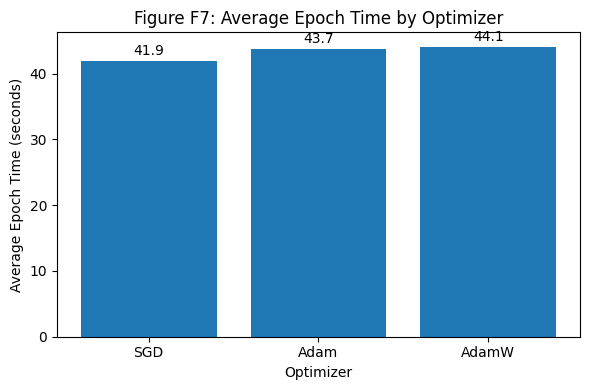

In [53]:
optimizers = ["SGD", "Adam", "AdamW"]

# Create figure
plt.figure(figsize=(6, 4))
bars = plt.bar(optimizers, avg_epoch_time)

# Add labels and title
plt.xlabel("Optimizer")
plt.ylabel("Average Epoch Time (seconds)")
plt.title("Figure F7: Average Epoch Time by Optimizer")

# Annotate values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5,
             f"{height:.1f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [54]:
print(avg_epoch_time, final_train_loss, avg_train_accuracy, final_test_accuracy)

[41.85001654624939, 43.70496792793274, 44.066245555877686] [0.6688132436226701, 0.0427789768023813, 0.03970071057877009] [0.60712, 0.9488480000000001, 0.9449759999999999] [0.79104, 0.8752, 0.86284]


In [61]:
wandb.termlog("Manually resetting W&B backend...")
wandb.finish()
wandb.teardown()

# Clear the global run object
wandb.run = None
wandb._thread_local = None

wandb: Manually resetting W&B backend...


In [62]:
wandb.init(project=project_name, group="Optimizer Comparison", name="C7_result")
records = []
optimizers = ["SGD", "Adam", "AdamW"]
for i in range(len(optimizers)):
    records.append({
        "Optimizer": optimizers[i],
        "Avg Epoch Time": avg_epoch_time[i],
        "Final Train Loss": final_train_loss[i],
        "Train Acc": avg_train_accuracy[i],
        "Test Acc": final_test_accuracy[i]
    })

df = pd.DataFrame(records)
wandb.log({"C7_result":wandb.Table(dataframe=df)})
wandb.finish()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


# C8

In [92]:

final_test_accuracy = []
avg_train_accuracy = []
final_train_loss = []
first_epoch_time = []
avg_afterwards_epoch_time = []
def train_C8():
  with wandb.init(
    group="Eagar vs. Compile",
    config={
        "model_name": "distilbert-base-uncased",
        "max_len": 256, 
        "batch_size": 32,
        "learning_rate": 1e-4,
        "optimizer": "AdamW",
        "num_workers": 2,
        "epochs": 10, 
    }) as run:
      config = wandb.config

      run.name = f"lr{wandb.config.learning_rate}_bs{wandb.config.batch_size}_compile{config.compile_mode}_C8"
      train_loader = DataLoader(tokenized["train"], batch_size=config.batch_size, shuffle=True, collate_fn=data_collator, num_workers=config.num_workers)
      test_loader = DataLoader(tokenized["test"], batch_size=config.batch_size, collate_fn=data_collator, num_workers=config.num_workers)
      model_name = "distilbert-base-uncased"
      model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
      if (config.compile_mode == True):
        model = torch.compile(model, backend="inductor")
      model.to(device)
      print(type(model))

      sum_train_accuracy = 0
    
      optimizer = getattr(optim, config.optimizer)(model.parameters(), lr=config.learning_rate)
      print(f"---------start train: batch_size({config.batch_size}) lr({config.learning_rate}) num_workers({config.num_workers}) optimizer({config.optimizer})-----")
      train_loss = []
      train_accuracy = []
      test_accuracy = []
      data_loading_time_arr = []
      compute_time_arr = []
      epoch_time_arr = []
      avg_loss = 0
      sum_epoch_time = 0
    
      for epoch in range(config.epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        data_loading_time = 0
        training_compute_time = 0
        total_epoch_time = 0
        start_data_loading = time.time()
        start_epoch_time = time.time()
        for batch in train_loader:
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
                "labels": batch["labels"].to(device),
            }
            torch.cuda.synchronize()
            end = time.time()
            data_loading_time +=  end - start_data_loading

            start_compute = time.time()
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
    
            torch.cuda.synchronize()
            end = time.time()
            training_compute_time += end - start_compute
    
            logits = outputs.logits
            preds = torch.argmax(logits, dim = 1)
            labels = batch["labels"].to(device)
            correct = (preds == labels).sum().item()
            total_correct += correct
            total_samples += len(labels)
            total_loss += loss.item()
    
            start_data_loading = time.time()
    
        end = time.time()
        total_epoch_time = end - start_epoch_time
    
        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_correct / total_samples
        train_loss.append(avg_loss)
        train_accuracy.append(avg_accuracy)
        sum_train_accuracy += avg_accuracy
    
        model.eval()
        correct = 0
        total = 0
    
        with torch.no_grad():
            for batch in test_loader:
                inputs = {
                    "input_ids": batch["input_ids"].to(device),
                    "attention_mask": batch["attention_mask"].to(device),
                }
                labels = batch["labels"].to(device)
    
                logits = model(**inputs).logits
                preds = torch.argmax(logits, dim=1)
    
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        
        if epoch == 0:
            first_epoch_time.append(total_epoch_time)
        if epoch >= 5:
            sum_epoch_time += total_epoch_time
    
        accuracy = correct / total
        test_accuracy.append(accuracy)
    
        wandb.log({"train/loss": train_loss,
                  "train/acc": avg_accuracy,
                  "test/acc": accuracy,
                  "data-loading time": data_loading_time,
                  "compute time": training_compute_time,
                  "total epoch time": total_epoch_time})
    
        data_loading_time_arr.append(data_loading_time)
        compute_time_arr.append(training_compute_time)
        epoch_time_arr.append(total_epoch_time)
        print(f"Epoch {epoch+1}/{config.epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {avg_accuracy:.4f}, Test Accuracy: {accuracy:.4f}, data_loading time: {data_loading_time} \
                compute time: {training_compute_time} total epoch time: {total_epoch_time}")
        print(f"-------------------------------------------------------------------------------")
        
      avg_epoch_time.append(sum(epoch_time_arr)/len(epoch_time_arr))
      avg_train_accuracy.append(sum_train_accuracy/config.epochs)
      final_train_loss.append(avg_loss)
      avg_afterwards_epoch_time.append(sum_epoch_time / 5)

      model.eval()
      correct = 0
      total = 0
    
      with torch.no_grad():
          for batch in test_loader:
              inputs = {
                  "input_ids": batch["input_ids"].to(device),
                  "attention_mask": batch["attention_mask"].to(device),
              }
              labels = batch["labels"].to(device)
    
              logits = model(**inputs).logits
              preds = torch.argmax(logits, dim=1)
    
              correct += (preds == labels).sum().item()
              total += labels.size(0)
    
      accuracy = correct / total
      final_test_accuracy.append(accuracy)
      

In [93]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        "compile_mode":{'values': [True, False]}
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)

wandb.agent(sweep_id, function=train_C8, count=2)
wandb.finish()


Create sweep with ID: vnlmen3k
Sweep URL: https://wandb.ai/kaimao-columbia-university/hpml-hw2-llm3/sweeps/vnlmen3k


wandb: Agent Starting Run: sv3pboqa with config:
wandb: 	compile_mode: True
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<class 'torch._dynamo.eval_frame.OptimizedModule'>
---------start train: batch_size(32) lr(0.0001) num_workers(2) optimizer(AdamW)-----


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 1/10, Loss: 0.3247, Train Accuracy: 0.8597, Test Accuracy: 0.8744, data_loading time: 1.418013572692871                 compute time: 39.92075705528259 total epoch time: 41.62350416183472
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 2/10, Loss: 0.1737, Train Accuracy: 0.9368, Test Accuracy: 0.8906, data_loading time: 1.3532395362854004                 compute time: 40.57009410858154 total epoch time: 42.201220989227295
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 3/10, Loss: 0.0839, Train Accuracy: 0.9709, Test Accuracy: 0.8723, data_loading time: 1.2285313606262207                 compute time: 40.77458333969116 total epoch time: 42.26802182197571
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 4/10, Loss: 0.0574, Train Accuracy: 0.9813, Test Accuracy: 0.8733, data_loading time: 1.4076130390167236                 compute time: 40.84573483467102 total epoch time: 42.535831689834595
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 5/10, Loss: 0.0402, Train Accuracy: 0.9872, Test Accuracy: 0.8639, data_loading time: 1.2851331233978271                 compute time: 40.803165912628174 total epoch time: 42.35278344154358
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 6/10, Loss: 0.0333, Train Accuracy: 0.9900, Test Accuracy: 0.8663, data_loading time: 1.2399680614471436                 compute time: 40.78580164909363 total epoch time: 42.29357385635376
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 7/10, Loss: 0.0282, Train Accuracy: 0.9916, Test Accuracy: 0.8474, data_loading time: 1.2487611770629883                 compute time: 40.74176549911499 total epoch time: 42.25001811981201
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 8/10, Loss: 0.0314, Train Accuracy: 0.9901, Test Accuracy: 0.8421, data_loading time: 1.2696943283081055                 compute time: 40.7682466506958 total epoch time: 42.306559562683105
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 9/10, Loss: 0.0235, Train Accuracy: 0.9931, Test Accuracy: 0.8475, data_loading time: 1.4323551654815674                 compute time: 40.78888440132141 total epoch time: 42.504047870635986
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 10/10, Loss: 0.0248, Train Accuracy: 0.9932, Test Accuracy: 0.8440, data_loading time: 1.2908835411071777                 compute time: 40.68842148780823 total epoch time: 42.23023557662964
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁▆▇███▇▇█▇
data-loading time,█▅▁▇▃▁▂▂█▃
test/acc,▆█▅▅▄▄▂▁▂▁
total epoch time,▁▅▆█▇▆▆▆█▆
train/acc,▁▅▇▇██████
compute time,40.68842
data-loading time,1.29088
test/acc,0.84404
total epoch time,42.23024
train/acc,0.99316


wandb: Agent Starting Run: 279apgn7 with config:
wandb: 	compile_mode: False
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'>
---------start train: batch_size(32) lr(0.0001) num_workers(2) optimizer(AdamW)-----


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 1/10, Loss: 0.2992, Train Accuracy: 0.8761, Test Accuracy: 0.8953, data_loading time: 1.238447666168213                 compute time: 42.158151149749756 total epoch time: 43.7539918422699
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 2/10, Loss: 0.1709, Train Accuracy: 0.9364, Test Accuracy: 0.8832, data_loading time: 1.3002090454101562                 compute time: 42.42946457862854 total epoch time: 44.071531534194946
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 3/10, Loss: 0.0895, Train Accuracy: 0.9689, Test Accuracy: 0.8903, data_loading time: 1.3439393043518066                 compute time: 42.43321990966797 total epoch time: 44.14191269874573
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 4/10, Loss: 0.0549, Train Accuracy: 0.9814, Test Accuracy: 0.8730, data_loading time: 1.3206939697265625                 compute time: 42.394832372665405 total epoch time: 44.070712089538574
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 5/10, Loss: 0.0367, Train Accuracy: 0.9873, Test Accuracy: 0.8738, data_loading time: 1.6793389320373535                 compute time: 42.599968671798706 total epoch time: 44.69762635231018
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 6/10, Loss: 0.0345, Train Accuracy: 0.9886, Test Accuracy: 0.8768, data_loading time: 1.434535026550293                 compute time: 42.40711259841919 total epoch time: 44.21923112869263
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 7/10, Loss: 0.0279, Train Accuracy: 0.9905, Test Accuracy: 0.8475, data_loading time: 1.2670419216156006                 compute time: 42.32213115692139 total epoch time: 43.94996213912964
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 8/10, Loss: 0.0249, Train Accuracy: 0.9910, Test Accuracy: 0.8602, data_loading time: 1.3984229564666748                 compute time: 42.26859664916992 total epoch time: 44.03139567375183
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 9/10, Loss: 0.0235, Train Accuracy: 0.9925, Test Accuracy: 0.8422, data_loading time: 1.555617332458496                 compute time: 42.46973276138306 total epoch time: 44.43778443336487
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 10/10, Loss: 0.0201, Train Accuracy: 0.9942, Test Accuracy: 0.8427, data_loading time: 1.699692726135254                 compute time: 42.58069634437561 total epoch time: 44.717750787734985
-------------------------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


compute time,▁▅▅▅█▅▄▃▆█
data-loading time,▁▂▃▂█▄▁▃▆█
test/acc,█▆▇▅▅▆▂▃▁▁
total epoch time,▁▃▄▃█▄▂▃▆█
train/acc,▁▅▇▇██████
compute time,42.5807
data-loading time,1.69969
test/acc,0.84268
total epoch time,44.71775
train/acc,0.99416


[41.62350416183472, 43.7539918422699]


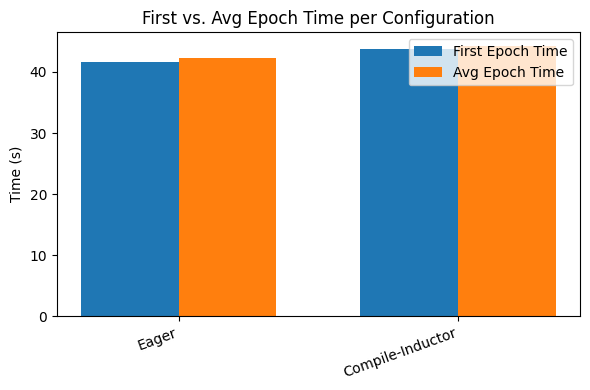

In [94]:
labels = ["Eager", "Compile-Inductor"]

x = np.arange(len(labels))
bar_width = 0.35

print(first_epoch_time)
# Plot
plt.figure(figsize=(6, 4))
plt.bar(x - bar_width/2, first_epoch_time, width=bar_width, label="First Epoch Time")
plt.bar(x + bar_width/2, avg_afterwards_epoch_time, width=bar_width, label="Avg Epoch Time")

# Formatting
plt.xticks(x, labels, rotation=20, ha='right')
plt.ylabel("Time (s)")
plt.title("First vs. Avg Epoch Time per Configuration")
plt.legend()
plt.tight_layout()
plt.show()

In [95]:
print(first_epoch_time, avg_afterwards_epoch_time)

[41.62350416183472, 43.7539918422699] [42.3168869972229, 44.27122483253479]


In [107]:
wandb.termlog("Manually resetting W&B backend...")
wandb.finish()
wandb.teardown()

# Clear the global run object
wandb.run = None
wandb._thread_local = None

wandb: Manually resetting W&B backend...


KeyboardInterrupt: 

In [101]:
wandb.init(project=project_name, name="C8 result", group="Eager vs. Compile")

records = []
mode = ["Eager", "Compile(Inductor)"]
for i in range(len(mode)):
    records.append({
        "Optimizer": mode[i],
        "First Epoch Time": first_epoch_time[i],
        "Avg Time Epochs 6-10": avg_afterwards_epoch_time[i]
    })

df = pd.DataFrame(records)
wandb.log({"C8_result":wandb.Table(dataframe=df)})
wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.
